In [1]:
%%capture output
%run ~/ligo-surf-18/ECCENTRIC_POWER_DISTRIBUTIONS/SPECTROGRAM_POWERDIST_FUNCTIONS.ipynb
%run ~/ligo-surf-18/Waveform_generation/Eccentric_Waveform_Generator_NO_GW.ipynb

## Necessary Functions 

$ \mathcal{M}_{chirp} = \eta^{3/5} \, M_{tot} $

$ M_{tot} = m_1 + m_2 $

$ \eta = \frac{m_1\,m_2}{M_{tot}^2}$

In [2]:
def componentmasses(mc, ratio): # mc = chirp mass, ratio = eta
    
    # Calculate total mass 
    mtot = mc/(ratio**(3.0/5))

    # Calculate component masses
    m1 = 0.5*(mtot - np.sqrt(mtot**2 - 4*ratio*mtot**2))
    m2 = 0.5*(mtot + np.sqrt(mtot**2 - 4*ratio*mtot**2))
    
    return mtot, m1, m2

In [3]:
def genSpec_mywaveform_nogw(P0,e0,m1,m2,dt,dist, *args, **kwargs):
    
    # Generate time series
    hp, hc, ts = GenerateEccentricWaveformNOGW(P0,e0,m1,m2,dt,dist) 
    hplus = TimeSeries(hp, dt=dt)
    hcross = TimeSeries(hc, dt=dt)
    
    # Calculate fftlength if necessary 
    if 'num_fft' in kwargs: 
        fftlen = hplus.duration/kwargs['num_fft']
    elif 'fftlen' in kwargs: 
        fftlen = kwargs['fftlen']
    else:
        print "error: no fftlen or nfft given. fftlen defaulting to 1 sec."
        fftlen = 1
    
    # Generate spectrogram from time series
    specgram_p = hplus.spectrogram(fftlen, fftlength=fftlen, overlap=fftlen/2.0)
    specgram_c = hcross.spectrogram(fftlen, fftlength=fftlen, overlap=fftlen/2.0)
    
    specgram = specgram_p + specgram_c
    
    return specgram

## Parameter Space

In [4]:
# -- Defining Parameter Space --

# Mass parameters:
mchirp = [2, 10]
eta = [0.1, 0.25]

# Eccentricity: 
e0 = 0.3

# Other params: 
P0 = 0.1
dt = 0.0001
dist = 3.086e24 #100 Mpc

# For spectrogram: 
theta = 0 
nMax = 15

## Generating Spectrograms

In [5]:
specs_mywaveform = {}
specs_eccTD = {}

for mc in mchirp:
    for ratio in eta: 
        
        # Find total mass and component masses
        mtot, m1, m2 = componentmasses(mc, ratio)
        print "For mchirp = {} & eta = {}: mtot = {}, m1 = {}, m2 = {}".format(mc, ratio,
                                                                              np.round(mtot,3), 
                                                                              np.round(m1, 3),
                                                                              np.round(m2, 3))
        
        # Start w fftlength of 1
        fftlen = 1
        
        # Try fixed number of ffts instead of fftlength 
        #num_fft = 10
        
        # Generate spectrograms
        spec_mywaveform = genSpec_mywaveform_nogw(P0,e0,m1,m2,dt,dist,fftlen=fftlen)
        #spec_mywaveform = genSpec_mywaveform_nogw(P0,e0,m1,m2,dt,dist,num_fft=num_fft)
        print "Generated spectrogram from my waveform."
        spec_eccTD = genSpectrogram(e0, m1, m2, theta, fftlen=fftlen)
        #spec_eccTD = genSpectrogram(e0, m1, m2, theta, num_fft=num_fft)
        print "Generated spectrogram from eccTD."
        print " "
        
        # Adding to dict 
        key = (mc, ratio)
        specs_mywaveform[key] = spec_mywaveform
        specs_eccTD[key] = spec_eccTD

For mchirp = 2 & eta = 0.1: mtot = 7.962, m1 = 0.897, m2 = 7.065
Generated spectrogram from my waveform.
Generated spectrogram from eccTD.
 
For mchirp = 2 & eta = 0.25: mtot = 4.595, m1 = 2.297, m2 = 2.297
Generated spectrogram from my waveform.
Generated spectrogram from eccTD.
 
For mchirp = 10 & eta = 0.1: mtot = 39.811, m1 = 4.487, m2 = 35.324
Generated spectrogram from my waveform.
Generated spectrogram from eccTD.
 
For mchirp = 10 & eta = 0.25: mtot = 22.974, m1 = 11.487, m2 = 11.487
Generated spectrogram from my waveform.
Generated spectrogram from eccTD.
 


## Plotting

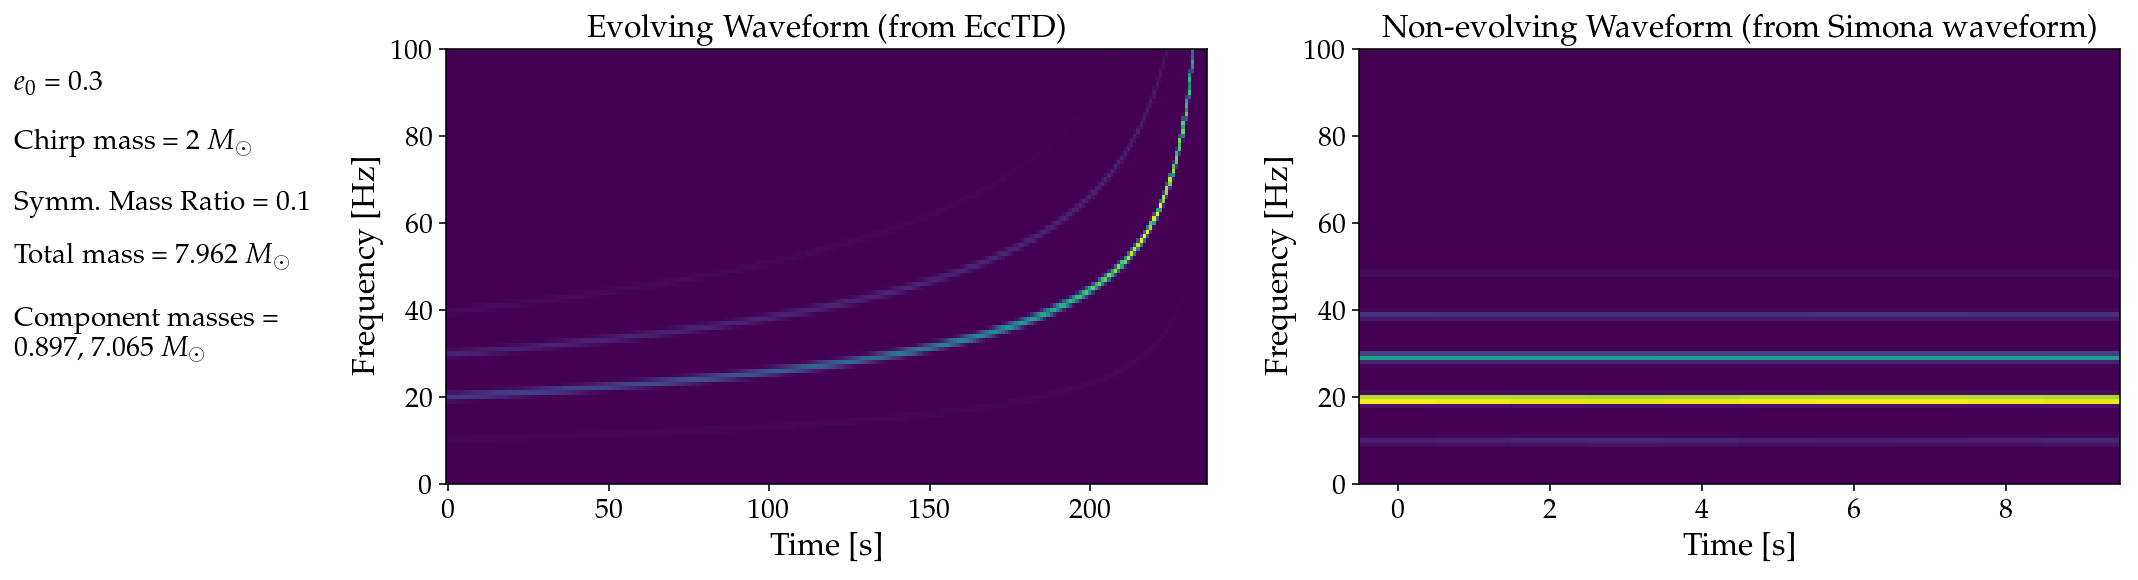

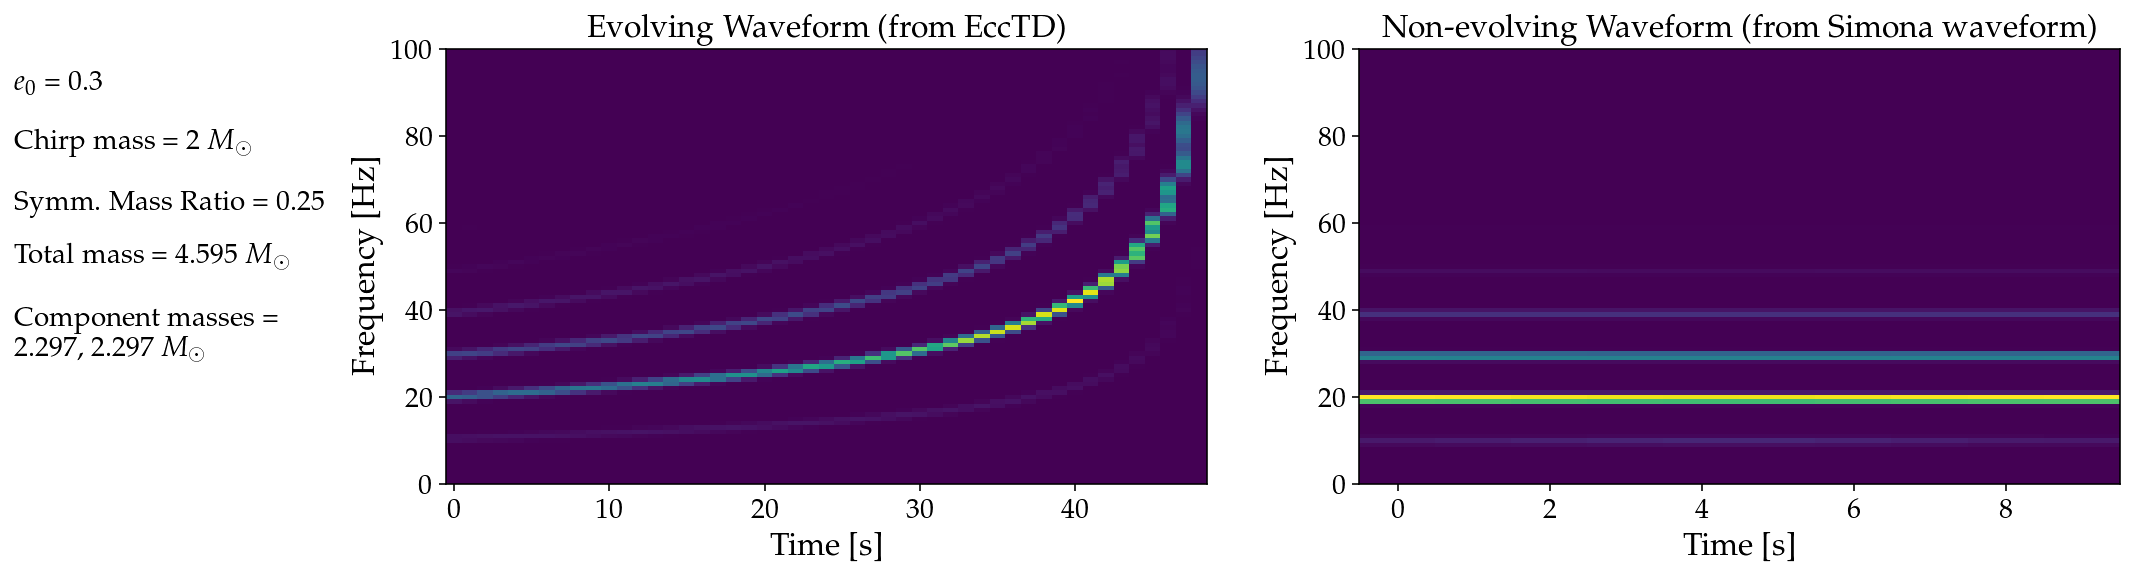

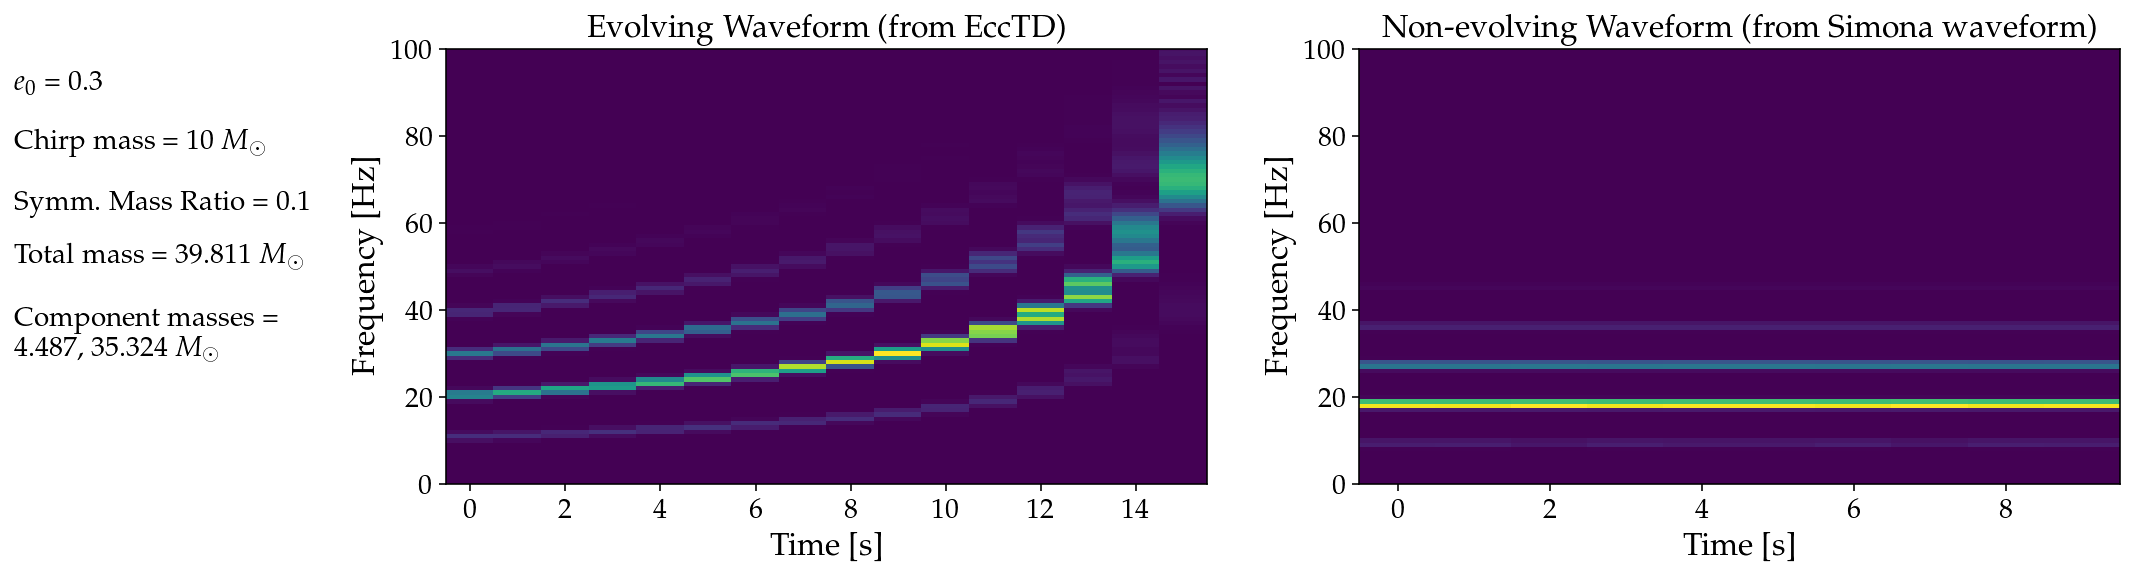

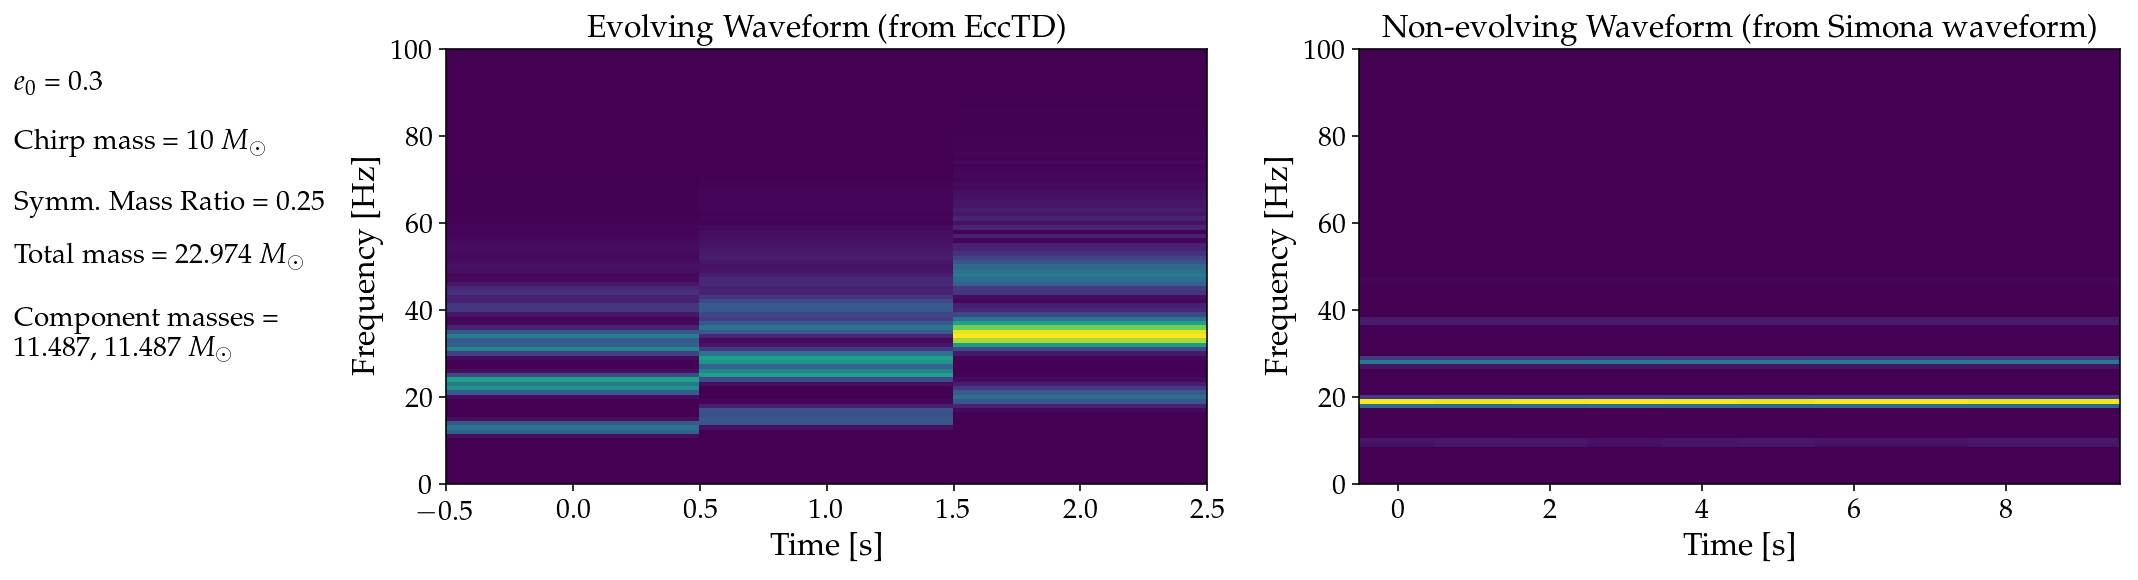

In [6]:
for mc in mchirp:
    for ratio in eta: 
        
        # Mass stuff
        key = (mc, ratio)
        mtot, m1, m2 = componentmasses(mc, ratio)
        
        # Generate plot 
        fig = plt.figure(figsize=(15,4))
        
        ax1 = fig.add_subplot(121)
        s1 = np.transpose(np.asarray(specs_eccTD[key]))
        spec1 = ax1.imshow(s1, aspect='auto')
        ax1.set_title("Evolving Waveform (from EccTD)", fontsize=16)
        ax1.set_ylabel("Frequency [Hz]", fontsize=16)
        ax1.set_xlabel("Time [s]", fontsize=16)
        ax1.set_ylim([0, 100])

        ax2 = fig.add_subplot(122)
        s2 = np.transpose(np.asarray(specs_mywaveform[key]))
        spec2 = ax2.imshow(s2, aspect='auto')
        ax2.set_title("Non-evolving Waveform (from Simona waveform)", fontsize=16)
        ax2.set_ylabel("Frequency [Hz]", fontsize=16)
        ax2.set_xlabel("Time [s]", fontsize=16)
        ax2.set_ylim([0, 100])
        
        # Adding text w info about mass parameters
        fig.text(-0.075, 0.8, r'$e_0$ = {}'.format(e0), fontsize=14)
        fig.text(-0.075, 0.7, r'Chirp mass = {} $M_\odot$'.format(mc), fontsize=14)
        fig.text(-0.075, 0.6, r'Symm. Mass Ratio = {}'.format(ratio), fontsize=14)
        fig.text(-0.075, 0.5, r'Total mass = {} $M_\odot$'.format(np.round(mtot,3)), fontsize=14)
        fig.text(-0.075, 0.4, r'Component masses =', fontsize=14)
        fig.text(-0.075, 0.34, r'{}, {} $M_\odot$'.format(np.round(m1,3), np.round(m2,3)), fontsize=14)